In [1]:
import logging

import cabinetry

We start by configuring the output from `cabinetry` and suppress output from `matplotlib`. 
This customization is optional and has no impact on the functionality.

In [2]:
logging.basicConfig(
    level=logging.INFO, format="%(levelname)s - %(name)s - %(message)s"
)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

## The configuration file

The configuration file is the central place to configure `cabinetry`.
Let's have a look at the example configuration file used in this notebook.

In [3]:
cabinetry_config = cabinetry.configuration.load("config_example.yml")
cabinetry.configuration.print_overview(cabinetry_config)

INFO - cabinetry.configuration - opening config file config_example.yml
INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   3 Sample(s)
INFO - cabinetry.configuration -   1 Regions(s)
INFO - cabinetry.configuration -   1 NormFactor(s)
INFO - cabinetry.configuration -   3 Systematic(s)


The configuration file is split into four different blocks of settings. There are general settings:

In [4]:
cabinetry_config["General"]

{'Measurement': 'minimal_example',
 'POI': 'Signal_norm',
 'HistogramFolder': 'histograms/',
 'InputPath': 'ntuples/{SamplePaths}'}

The list of phase space regions (channels), in this case we are considering just a single one:

In [5]:
cabinetry_config["Regions"]

[{'Name': 'Signal_region',
  'Variable': 'jet_pt',
  'Filter': 'lep_charge > 0',
  'Binning': [200, 300, 400, 500, 600]}]

A list of samples, including data:

In [6]:
cabinetry_config["Samples"]

[{'Name': 'Data',
  'Tree': 'pseudodata',
  'SamplePaths': 'data.root',
  'Data': True},
 {'Name': 'Signal',
  'Tree': 'signal',
  'SamplePaths': 'prediction.root',
  'Weight': 'weight'},
 {'Name': 'Background',
  'Tree': 'background',
  'SamplePaths': 'prediction.root',
  'Weight': 'weight'}]

A list of normalization factors:

In [7]:
cabinetry_config["NormFactors"]

[{'Name': 'Signal_norm', 'Samples': 'Signal', 'Nominal': 1, 'Bounds': [0, 10]}]

And finally a list of systematic uncertainties. In this case there are three systematic uncertainties:

In [8]:
cabinetry_config["Systematics"]

[{'Name': 'Luminosity',
  'Up': {'Normalization': 0.05},
  'Down': {'Normalization': -0.05},
  'Samples': ['Signal', 'Background'],
  'Type': 'Normalization'},
 {'Name': 'Modeling',
  'Up': {'SamplePaths': 'prediction.root', 'Tree': 'background_varied'},
  'Down': {'Symmetrize': True},
  'Samples': 'Background',
  'Type': 'NormPlusShape'},
 {'Name': 'WeightBasedModeling',
  'Up': {'Weight': 'weight_up'},
  'Down': {'Weight': '0.7*weight'},
  'Samples': 'Background',
  'Type': 'NormPlusShape'}]

Regions, samples, normalization factors and systematics all can be identified by their names.

## Creating template histograms

We use the `template_builder` module to create all histograms needed to build the workspace defined in the configuration file.

In [9]:
cabinetry.template_builder.create_histograms(cabinetry_config, method="uproot")

WARNING - cabinetry.histo - Signal_region_Signal_Nominal has empty bins: [0]


The histograms are saved to the folder specified under `HistogramFolder` in the `General` settings in the configuration file.
In this case, this folder is `histograms/`:

In [10]:
!ls histograms/

Signal_region_Background_Modeling_Up.npz
Signal_region_Background_Modeling_Up_modified.npz
Signal_region_Background_Nominal.npz
Signal_region_Background_Nominal_modified.npz
Signal_region_Background_WeightBasedModeling_Down.npz
Signal_region_Background_WeightBasedModeling_Down_modified.npz
Signal_region_Background_WeightBasedModeling_Up.npz
Signal_region_Background_WeightBasedModeling_Up_modified.npz
Signal_region_Data_Nominal.npz
Signal_region_Data_Nominal_modified.npz
Signal_region_Signal_Nominal.npz
Signal_region_Signal_Nominal_modified.npz


It can be useful to apply additional post-processing after building template histograms.
Such processing can for example replace ill-defined statistical uncertainties in empty bins by zero.
It is performed via the `template_postprocessor` module:

In [11]:
cabinetry.template_postprocessor.run(cabinetry_config)

WARNING - cabinetry.histo - Signal_region_Signal_Nominal has empty bins: [0]


New histograms have now appeard in the `histograms/` folder.
These "modified" histograms include the changes applied by the postprocessor.

In [12]:
!ls histograms/

Signal_region_Background_Modeling_Up.npz
Signal_region_Background_Modeling_Up_modified.npz
Signal_region_Background_Nominal.npz
Signal_region_Background_Nominal_modified.npz
Signal_region_Background_WeightBasedModeling_Down.npz
Signal_region_Background_WeightBasedModeling_Down_modified.npz
Signal_region_Background_WeightBasedModeling_Up.npz
Signal_region_Background_WeightBasedModeling_Up_modified.npz
Signal_region_Data_Nominal.npz
Signal_region_Data_Nominal_modified.npz
Signal_region_Signal_Nominal.npz
Signal_region_Signal_Nominal_modified.npz


## Workspace building

Next, we build a `pyhf` workspace and serialize it to a file.
The `workspace` module takes care of this task.

In [13]:
workspace_path = "workspaces/example_workspace.json"
ws = cabinetry.workspace.build(cabinetry_config)
cabinetry.workspace.save(ws, workspace_path)

INFO - cabinetry.workspace - building workspace
INFO - pyhf.workspace - Validating spec against schema: workspace.json


## Fitting

With the workspace build, we can perform a maximum likelihood fit.
The fit model (probability density function) and data (including auxiliary data for auxiliary measurements, see the HistFactory documentation https://cds.cern.ch/record/1456844) are obtained from the workspace object.
The results for the fitted parameters are reported.
The `cabinetry.model_utils.model_and_data` function has an `asimov` keyword argument, which we can set to true to instead study the expected performance with an Asimov dataset.

In [14]:
bws = cabinetry.workspace.load(workspace_path)
model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier staterror_Signal_region (4 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Signal_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Luminosity (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Modeling (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier WeightBasedModeling (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.19                      │              Nfcn = 327              │
│ EDM = 1.12e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├──────

We can also visualize the fit results.
Below are the pulls and the correlation matrix.

In [15]:
cabinetry.visualize.pulls(fit_results, exclude=["Signal_norm"])
cabinetry.visualize.correlation_matrix(fit_results)

Take a look at the `figures/` folder to see the visualizations, or see below.
We convert the `.pdf` figure to `.png` for viewing in this notebook via `ghostscript`.

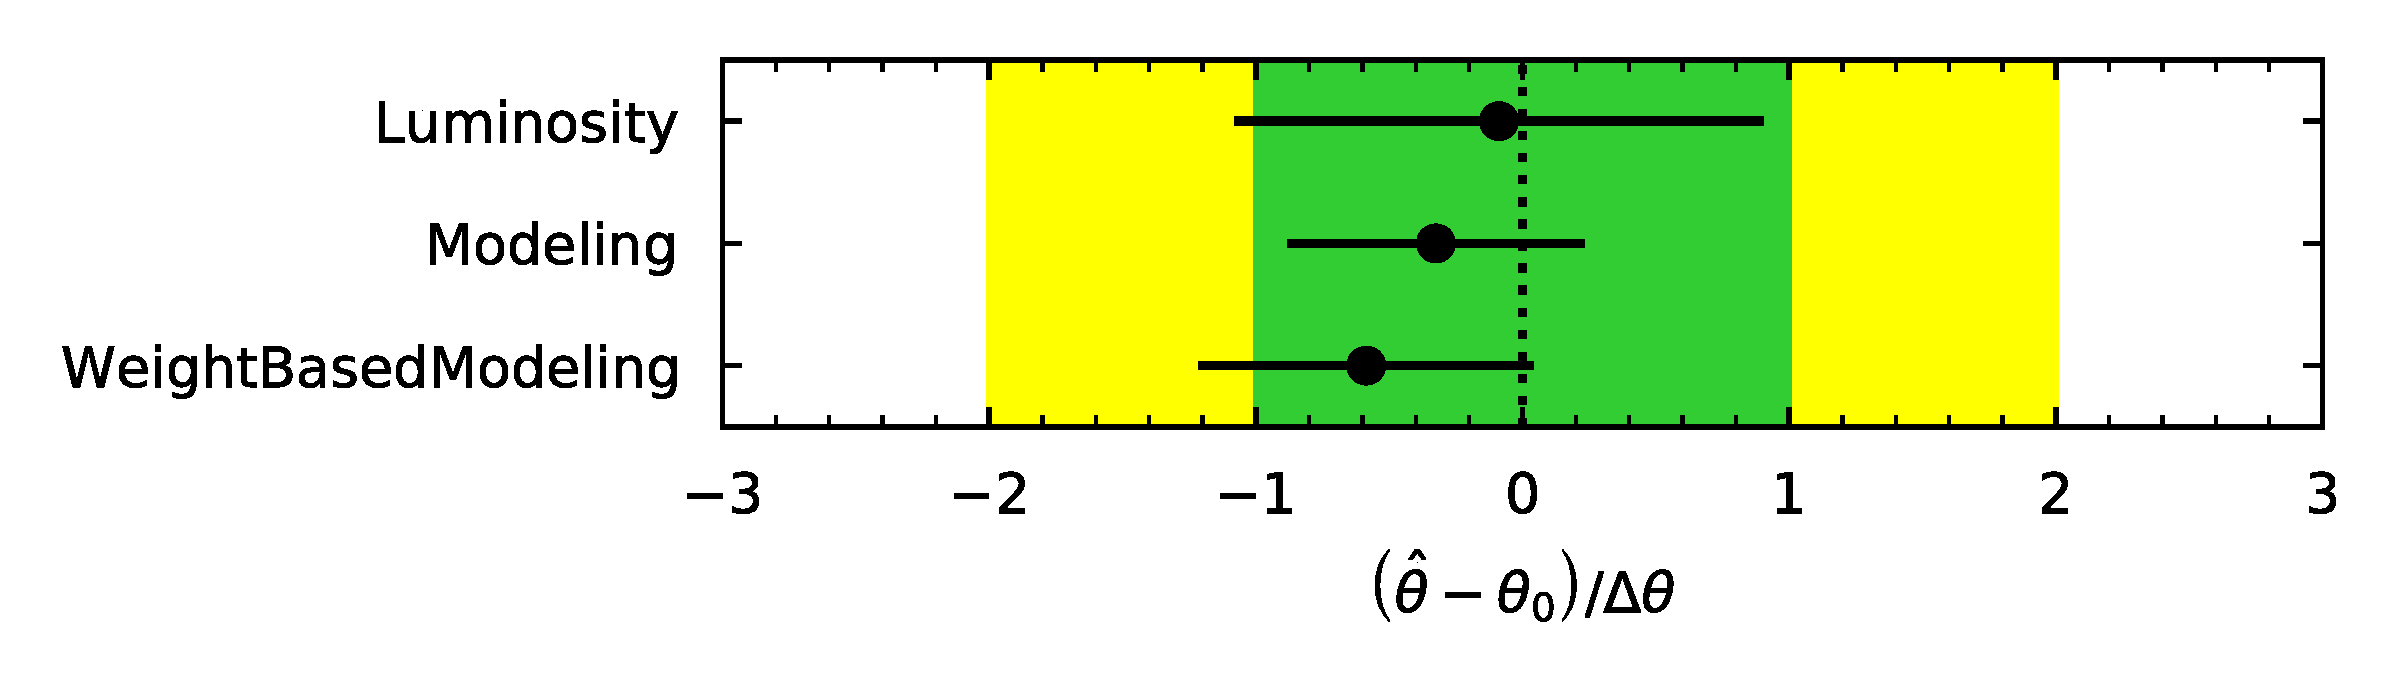

In [16]:
from IPython.display import Image
!gs -dSAFER -dBATCH -dNOPAUSE -dQUIET -sDEVICE=png16m -r400 -sOutputFile="figures/pulls.png" "figures/pulls.pdf"
Image("figures/pulls.png", width=500)

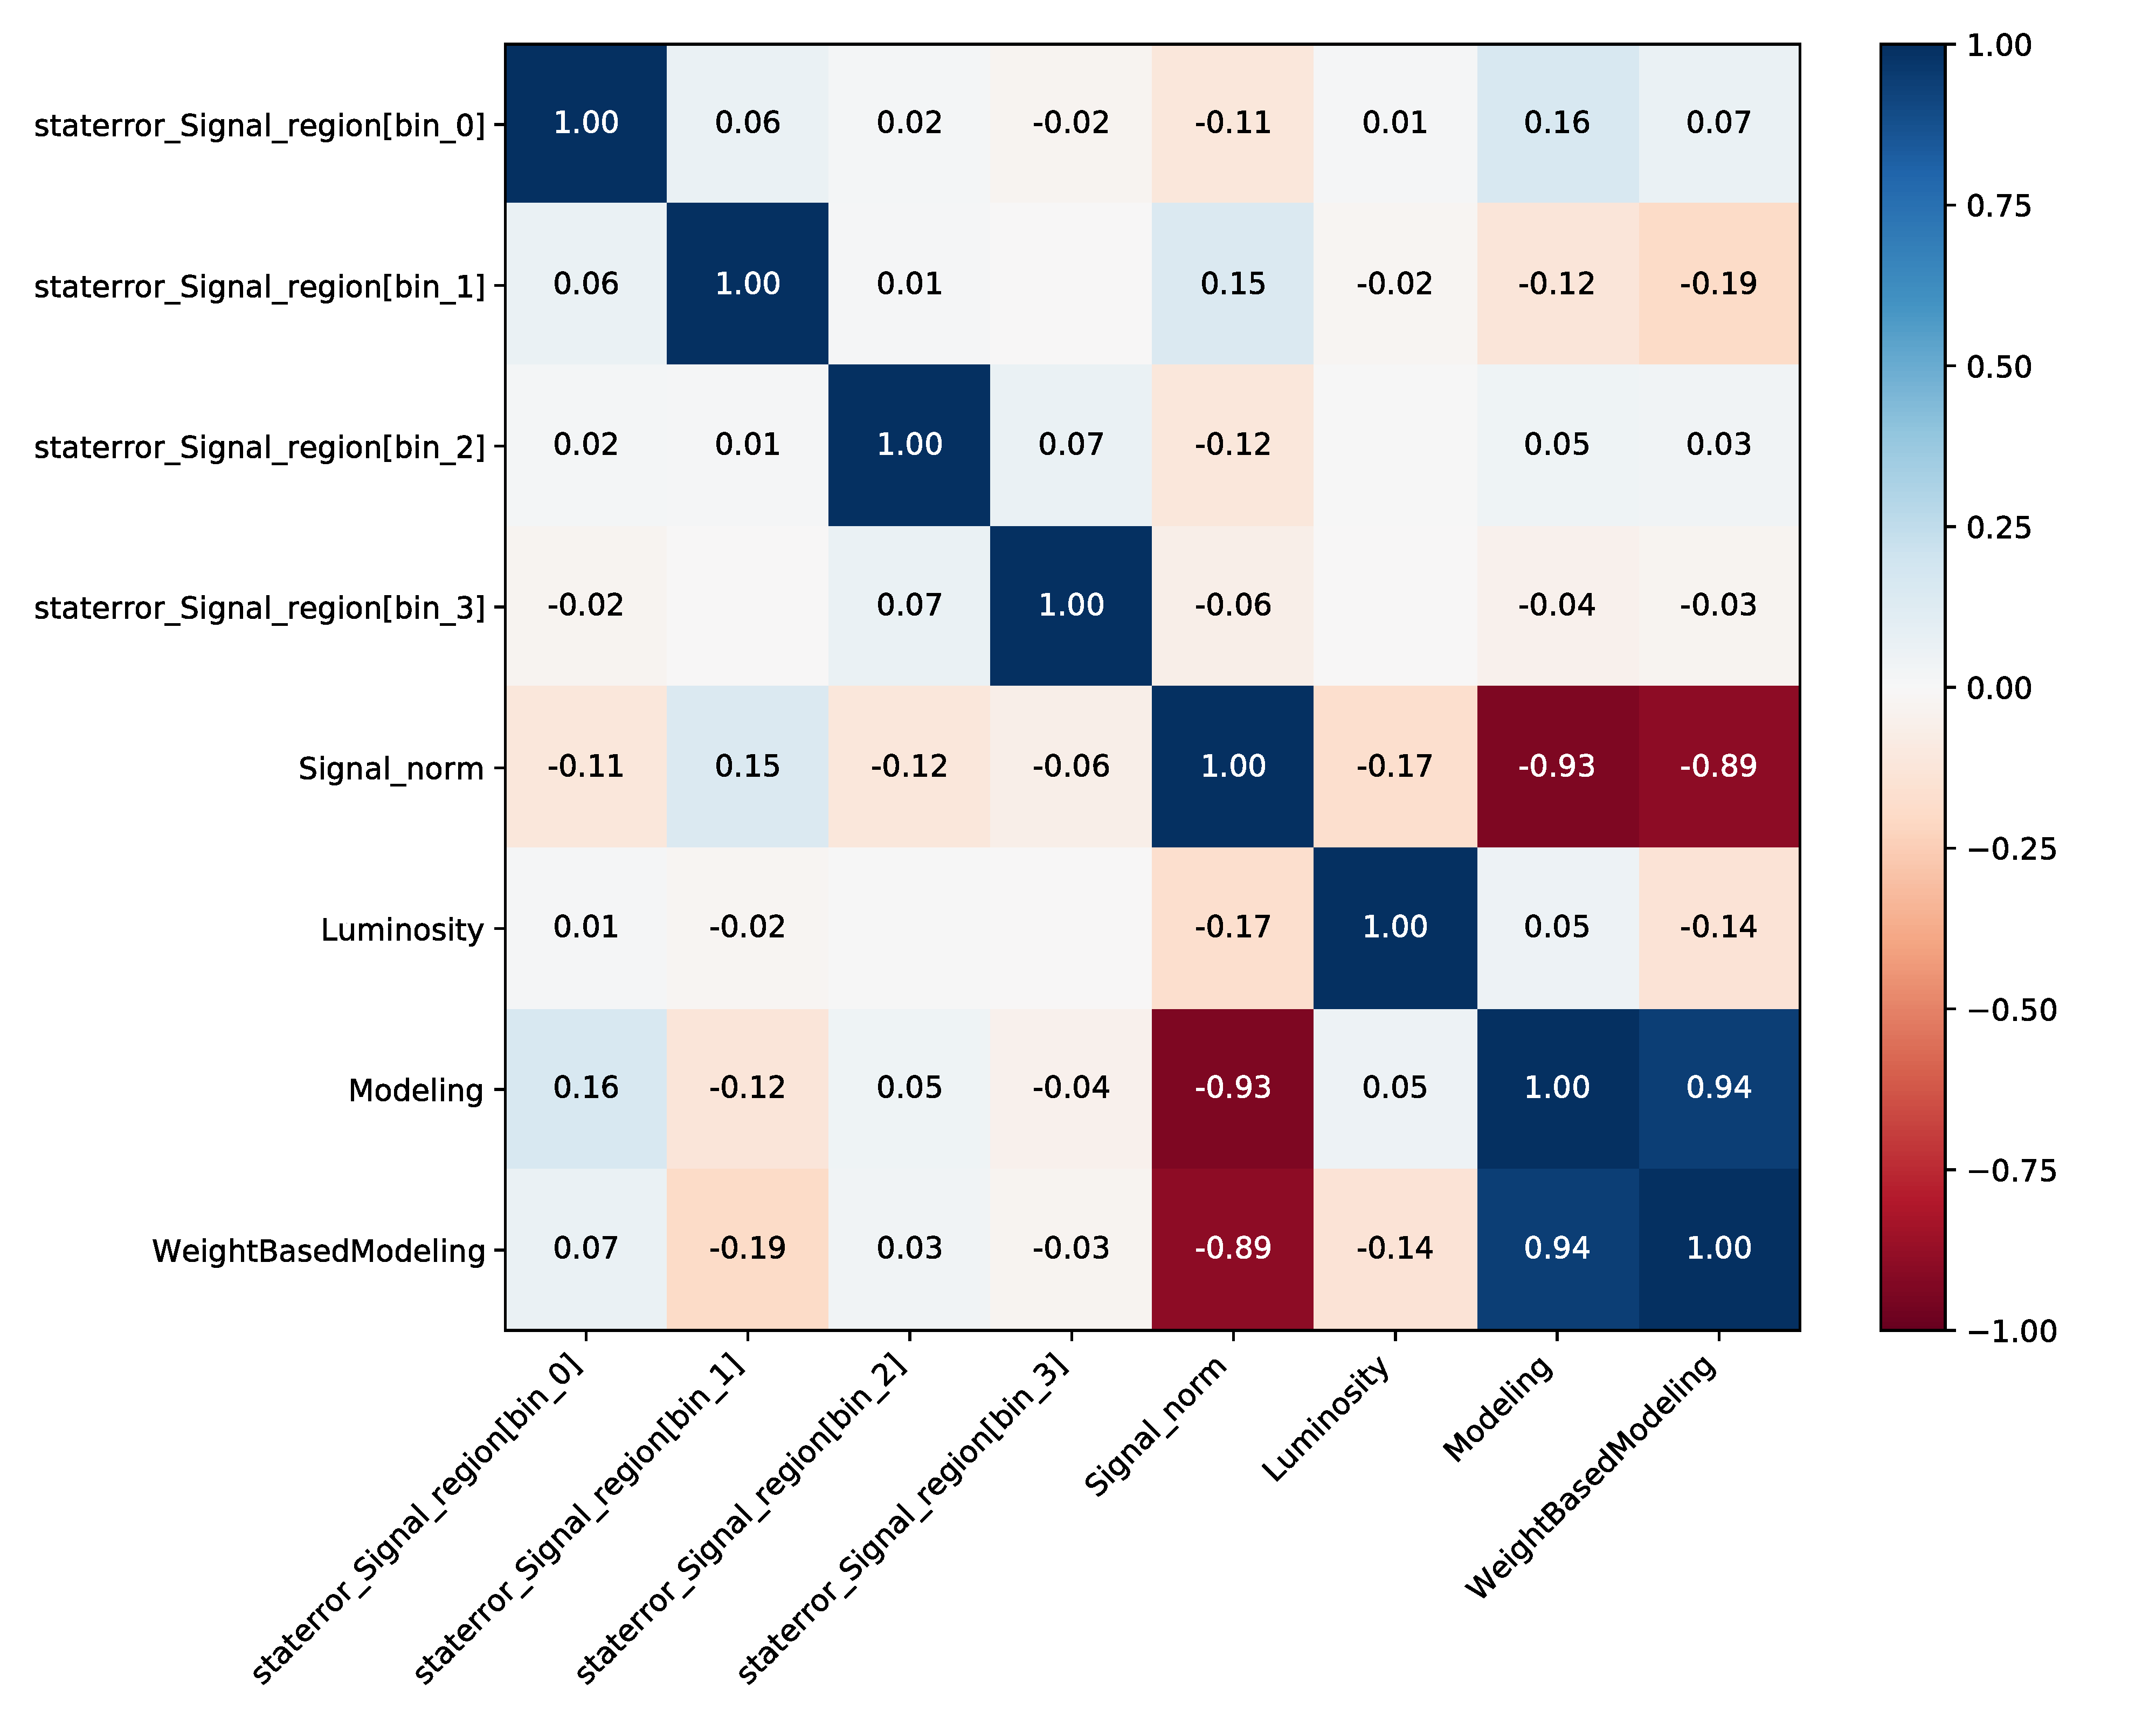

In [17]:
!gs -dSAFER -dBATCH -dNOPAUSE -dQUIET -sDEVICE=png16m -r400 \
  -sOutputFile="figures/correlation_matrix.png" "figures/correlation_matrix.pdf"
Image("figures/correlation_matrix.png", width=600)

## Visualizing templates

What did we fit?
The `visualize` module also contains functionality to plot data/MC distributions.
It also creates yield tables, both for yields per bin and for all bins in a region summed.
The `config` keyword argument is optional, but required for correct horizontal axis labels, since the observable and bin edges are not part of the `pyhf` workspace.
Since this argument is optional, you can use `cabinetry.visualize.data_MC` with any workspace: it does not matter whether it was created with `cabinetry` or otherwise, since you do not need a configuration file. 

In [18]:
cabinetry.visualize.data_MC(model, data, config=cabinetry_config)

INFO - cabinetry.visualize - generating pre-fit yield table
INFO - cabinetry.tabulate - yields per bin:
╒════════════╤═════════════════╤════════════════╤════════════════╤═══════════════╕
│ sample     │ Signal_region   │                │                │               │
│            │ bin 1           │ bin 2          │ bin 3          │ bin 4         │
╞════════════╪═════════════════╪════════════════╪════════════════╪═══════════════╡
│ Background │ 112.74          │ 128.62         │ 88.11          │ 55.25         │
├────────────┼─────────────────┼────────────────┼────────────────┼───────────────┤
│ Signal     │ 0.00            │ 1.59           │ 23.62          │ 24.55         │
├────────────┼─────────────────┼────────────────┼────────────────┼───────────────┤
│ total      │ 112.74 ± 69.04  │ 130.21 ± 58.34 │ 111.72 ± 38.22 │ 79.79 ± 45.30 │
├────────────┼─────────────────┼────────────────┼────────────────┼───────────────┤
│ data       │ 112.00          │ 112.00         │ 124.00         │

The figures are again found in the `figures/` folder.

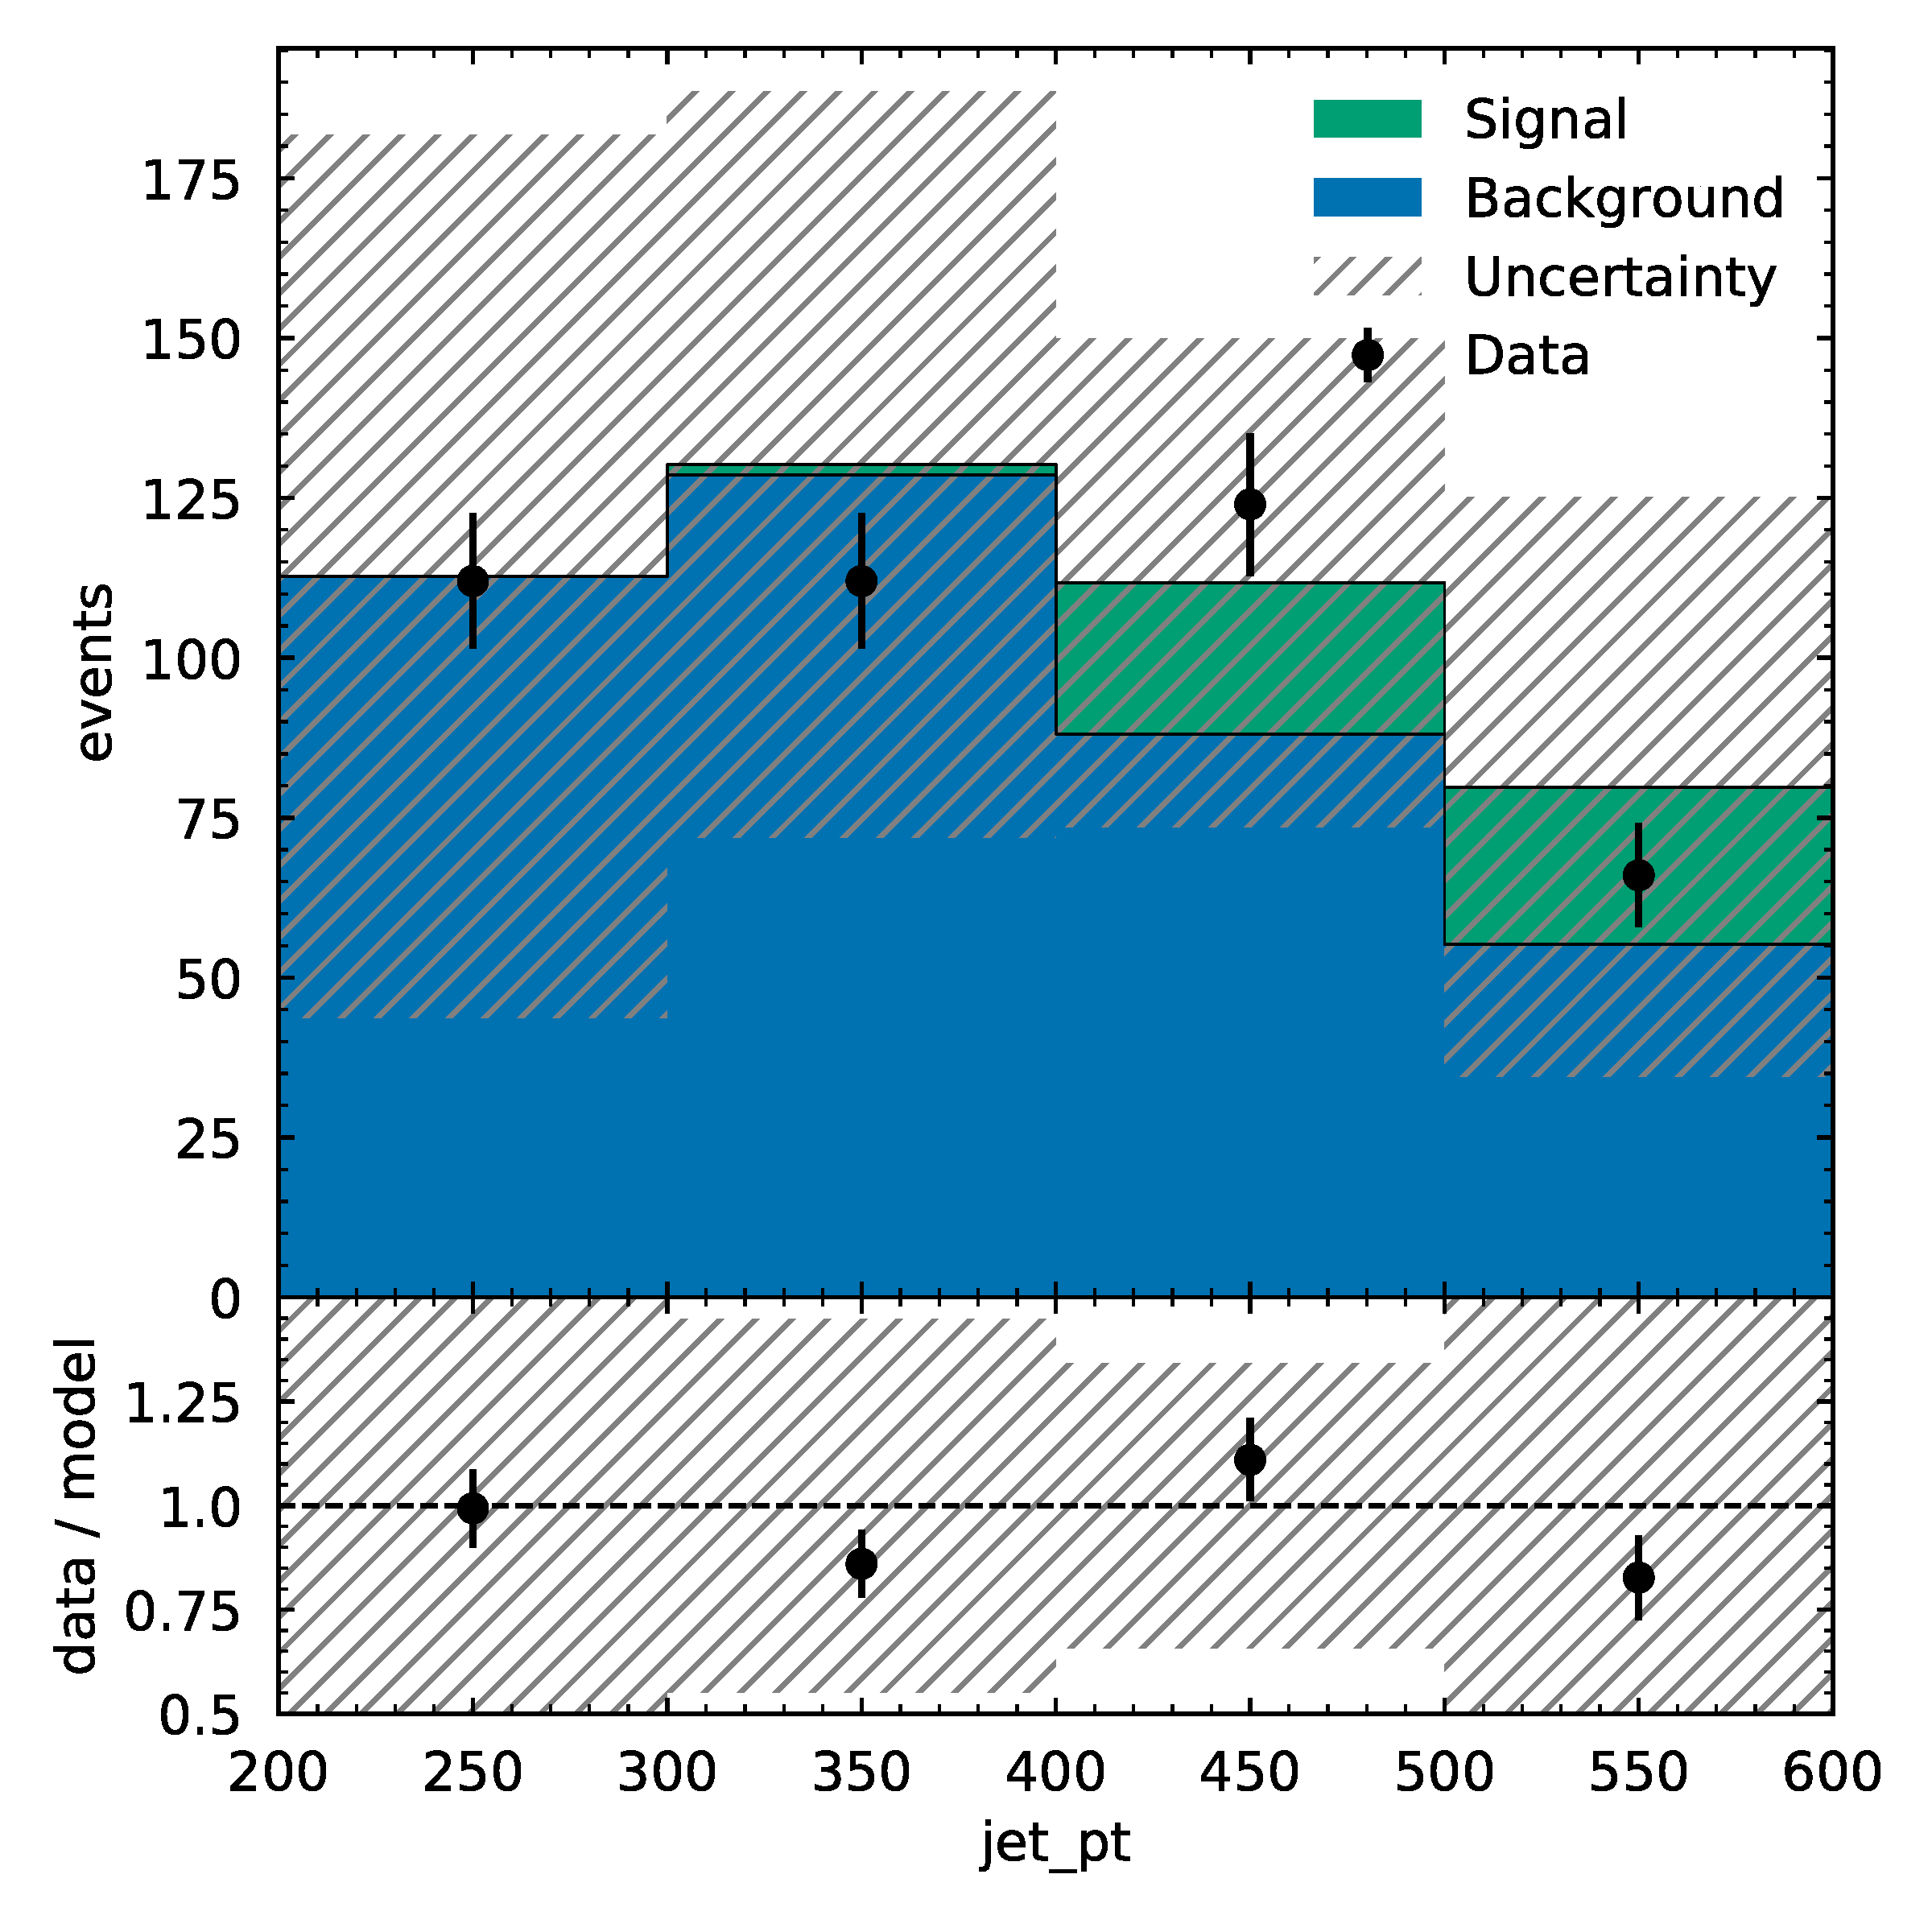

In [19]:
!gs -dSAFER -dBATCH -dNOPAUSE -dQUIET -sDEVICE=png16m -r400 \
  -sOutputFile="figures/Signal_region_prefit.png" "figures/Signal_region_prefit.pdf"
Image("figures/Signal_region_prefit.png", width=450)

We can also take a look at the post-fit model.

In [20]:
cabinetry.visualize.data_MC(model, data, config=cabinetry_config, fit_results=fit_results)

INFO - cabinetry.visualize - generating post-fit yield table
INFO - cabinetry.tabulate - yields per bin:
╒════════════╤═════════════════╤═══════════════╤═══════════════╤══════════════╕
│ sample     │ Signal_region   │               │               │              │
│            │ bin 1           │ bin 2         │ bin 3         │ bin 4        │
╞════════════╪═════════════════╪═══════════════╪═══════════════╪══════════════╡
│ Background │ 111.42          │ 116.36        │ 69.80         │ 34.42        │
├────────────┼─────────────────┼───────────────┼───────────────┼──────────────┤
│ Signal     │ 0.00            │ 2.64          │ 40.51         │ 40.59        │
├────────────┼─────────────────┼───────────────┼───────────────┼──────────────┤
│ total      │ 111.42 ± 11.90  │ 119.00 ± 7.28 │ 110.30 ± 7.41 │ 75.01 ± 7.69 │
├────────────┼─────────────────┼───────────────┼───────────────┼──────────────┤
│ data       │ 112.00          │ 112.00        │ 124.00        │ 66.00        │
╘════════════╧═

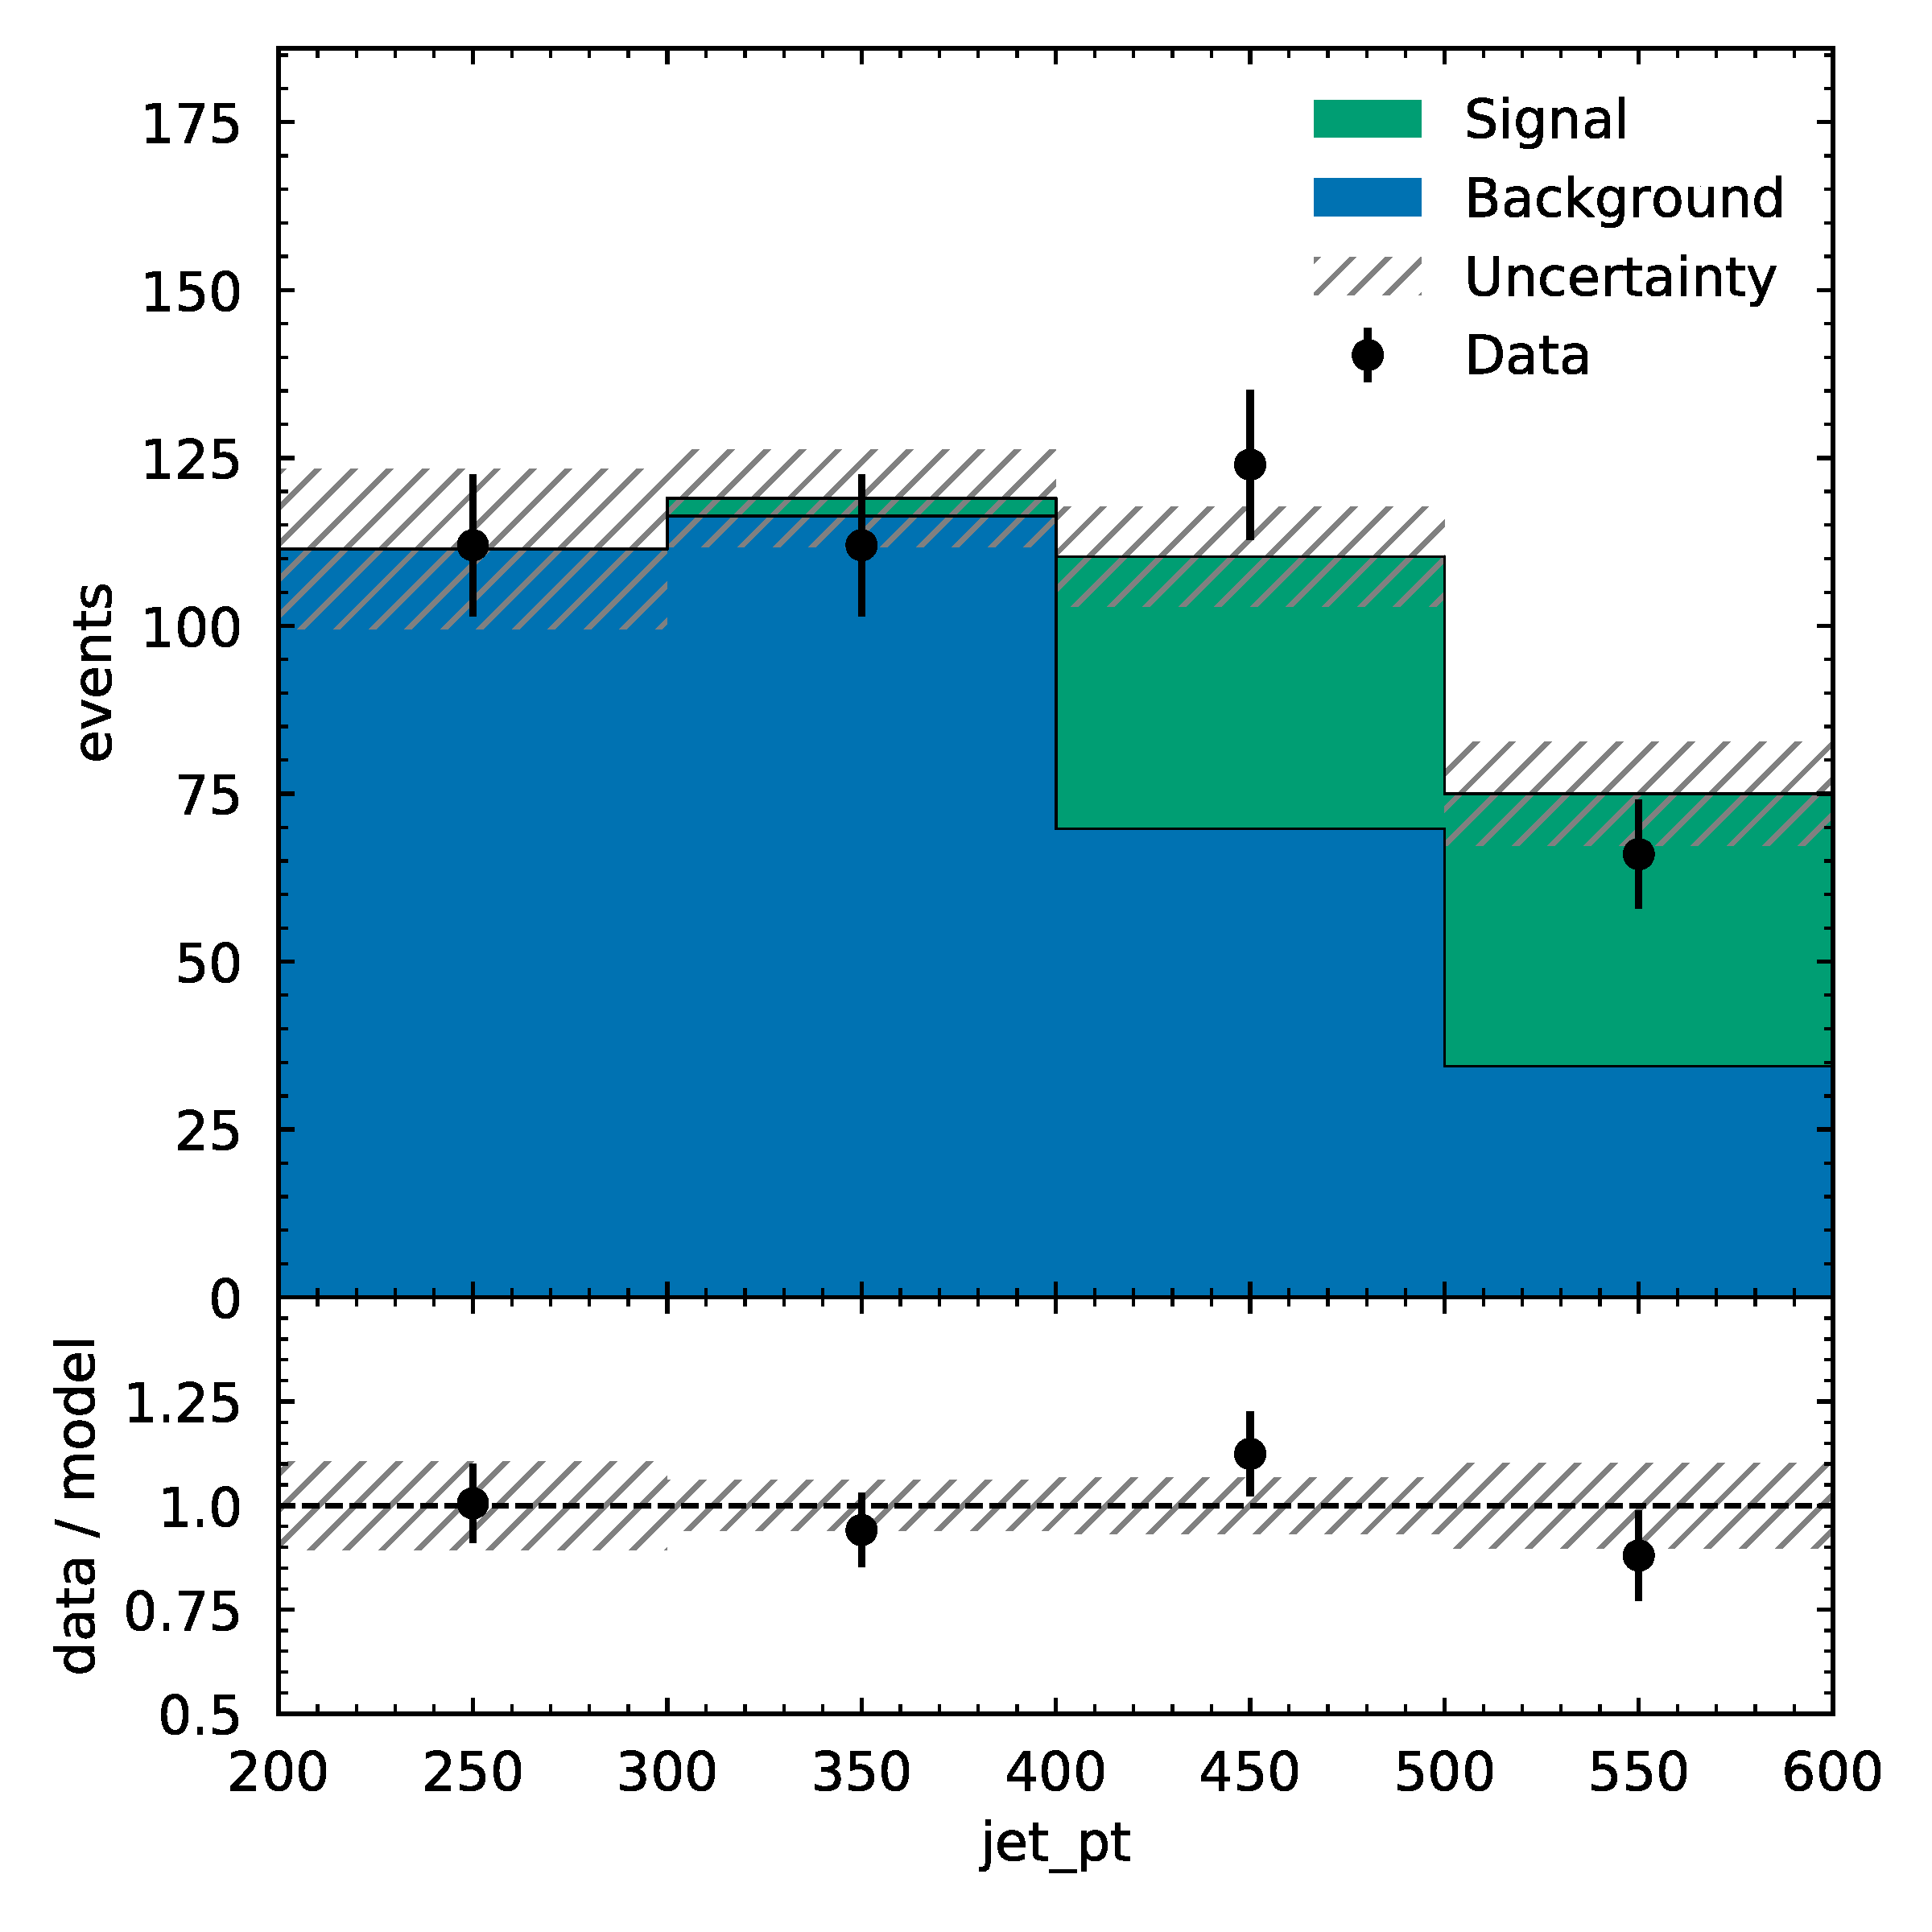

In [21]:
!gs -dSAFER -dBATCH -dNOPAUSE -dQUIET -sDEVICE=png16m -r400 \
  -sOutputFile="figures/Signal_region_postfit.png" "figures/Signal_region_postfit.pdf"
Image("figures/Signal_region_postfit.png", width=450)

## Beyond simple maximum likelihood fitting 

`cabinetry` provides a range of useful utilities for statistical inference besides simple maximum likelihood fitting.
To start, let's look at ranking nuisance parameters by their impact on the parameter of interest.

In [22]:
ranking_results = cabinetry.fit.ranking(model, data)
cabinetry.visualize.ranking(ranking_results)

INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.19                      │              Nfcn = 327              │
│ EDM = 1.12e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
INFO - cabinetry.fit - calculating impact of staterror_Signal_region[bin_0] on Signal_norm
INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬─────────────────────────────────────

INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.3                       │              Nfcn = 270              │
│ EDM = 6.29e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.19                      │              Nfcn = 269              │
│ EDM = 8.23

INFO - cabinetry.fit - calculating impact of Modeling on Signal_norm
INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 35.35                      │              Nfcn = 269              │
│ EDM = 2.69e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 20.47      

The results are contained in the `ranking_results` object, and have also been visualized:

In [23]:
ranking_results

RankingResults(bestfit=array([ 1.00102289,  0.98910429,  1.01970061,  0.98296235, -0.0880332 ,
       -0.32457145, -0.58582788]), uncertainty=array([0.04108188, 0.03792561, 0.03651562, 0.04250561, 0.99129285,
       0.55547829, 0.62723287]), labels=['staterror_Signal_region[bin_0]', 'staterror_Signal_region[bin_1]', 'staterror_Signal_region[bin_2]', 'staterror_Signal_region[bin_3]', 'Luminosity', 'Modeling', 'WeightBasedModeling'], prefit_up=array([-0.11067886,  0.14350015, -0.11311905, -0.05573699, -0.14964691,
       -1.67617185, -1.51531885]), prefit_down=array([ 0.10921276, -0.15331245,  0.11492629,  0.05864963,  0.16388633,
        1.41570164,  1.15001063]), postfit_up=array([-0.10774045,  0.13866138, -0.10800499, -0.05485056, -0.14842105,
       -1.10238193, -0.89699002]), postfit_down=array([ 0.10604552, -0.14383346,  0.10888305,  0.05779501,  0.1623609 ,
        0.84367903,  0.76574073]))

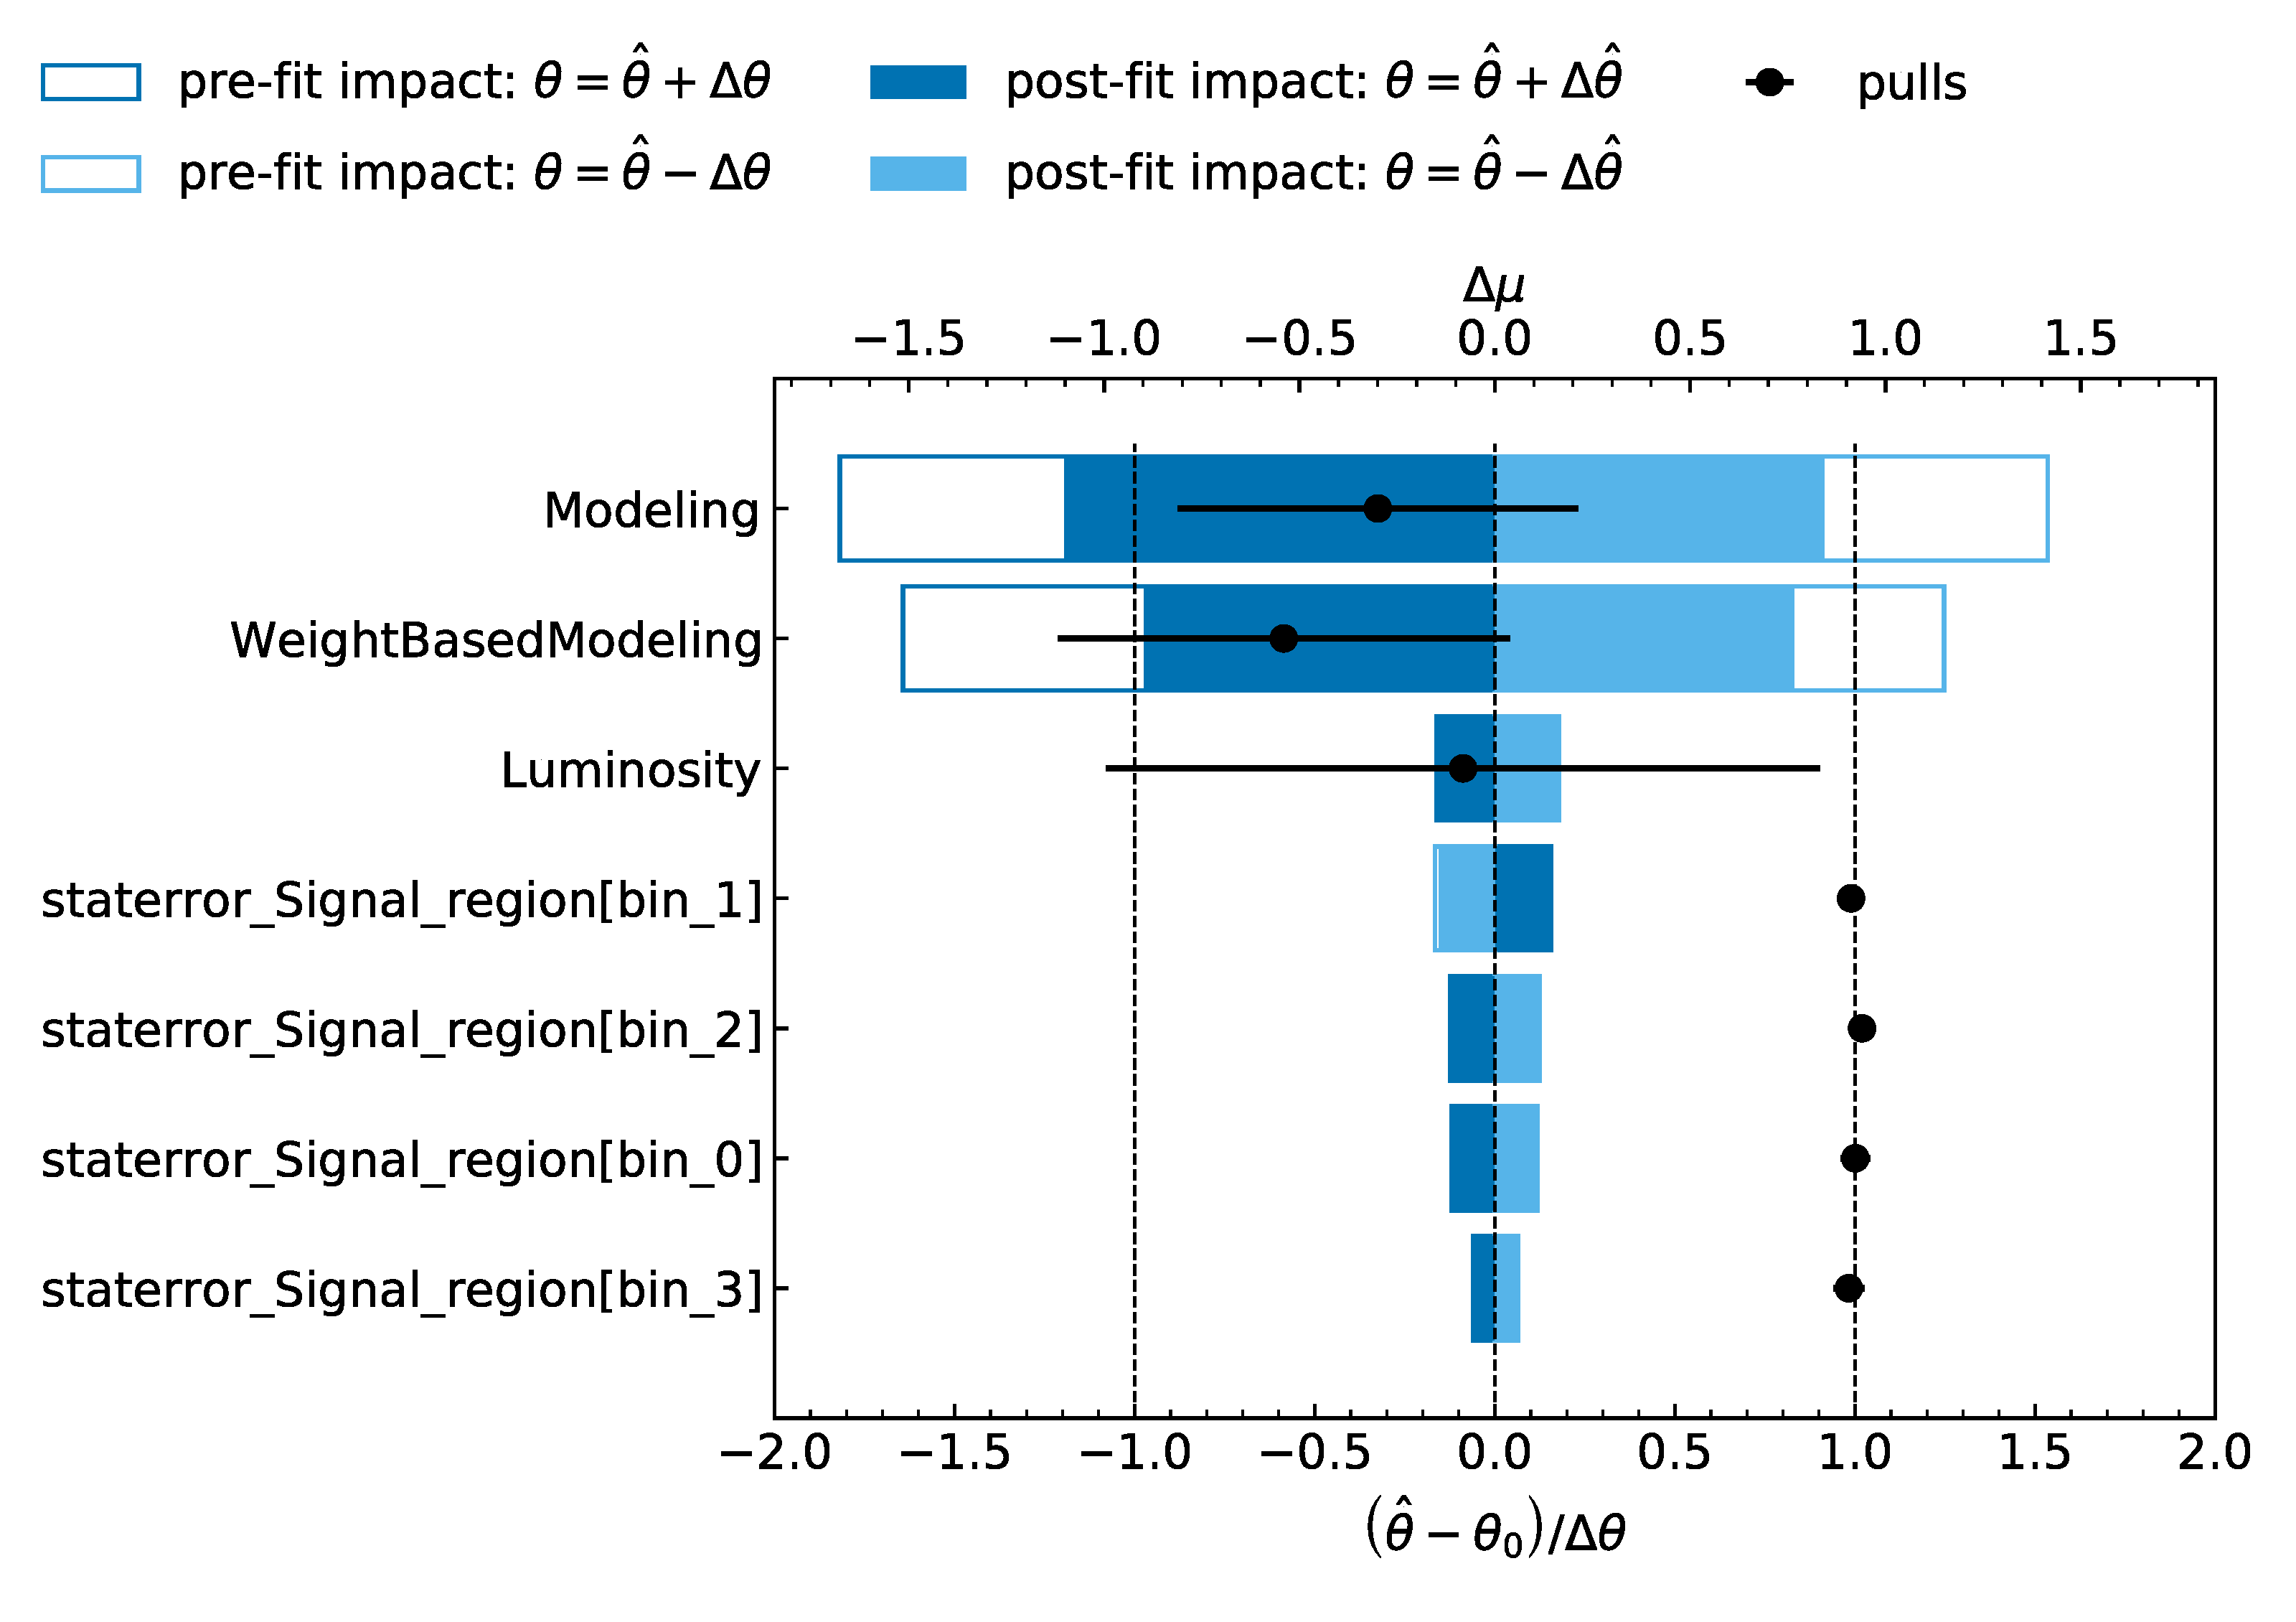

In [24]:
!gs -dSAFER -dBATCH -dNOPAUSE -dQUIET -sDEVICE=png16m -r400 \
  -sOutputFile="figures/ranking.png" "figures/ranking.pdf"
Image("figures/ranking.png", width=600)

We can also perform likelihood scans for parameters.
The example below performs a scan for the `Modeling` nuisance parameter.

In [25]:
scan_results = cabinetry.fit.scan(model, data, "WeightBasedModeling")
cabinetry.visualize.scan(scan_results)

INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.19                      │              Nfcn = 327              │
│ EDM = 1.12e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
INFO - cabinetry.fit - performing likelihood scan for WeightBasedModeling in range (-1.840, 0.669) with 11 steps
INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬───────────────

INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 23.48                      │              Nfcn = 253              │
│ EDM = 4.82e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘


The resulting figure looks like this:

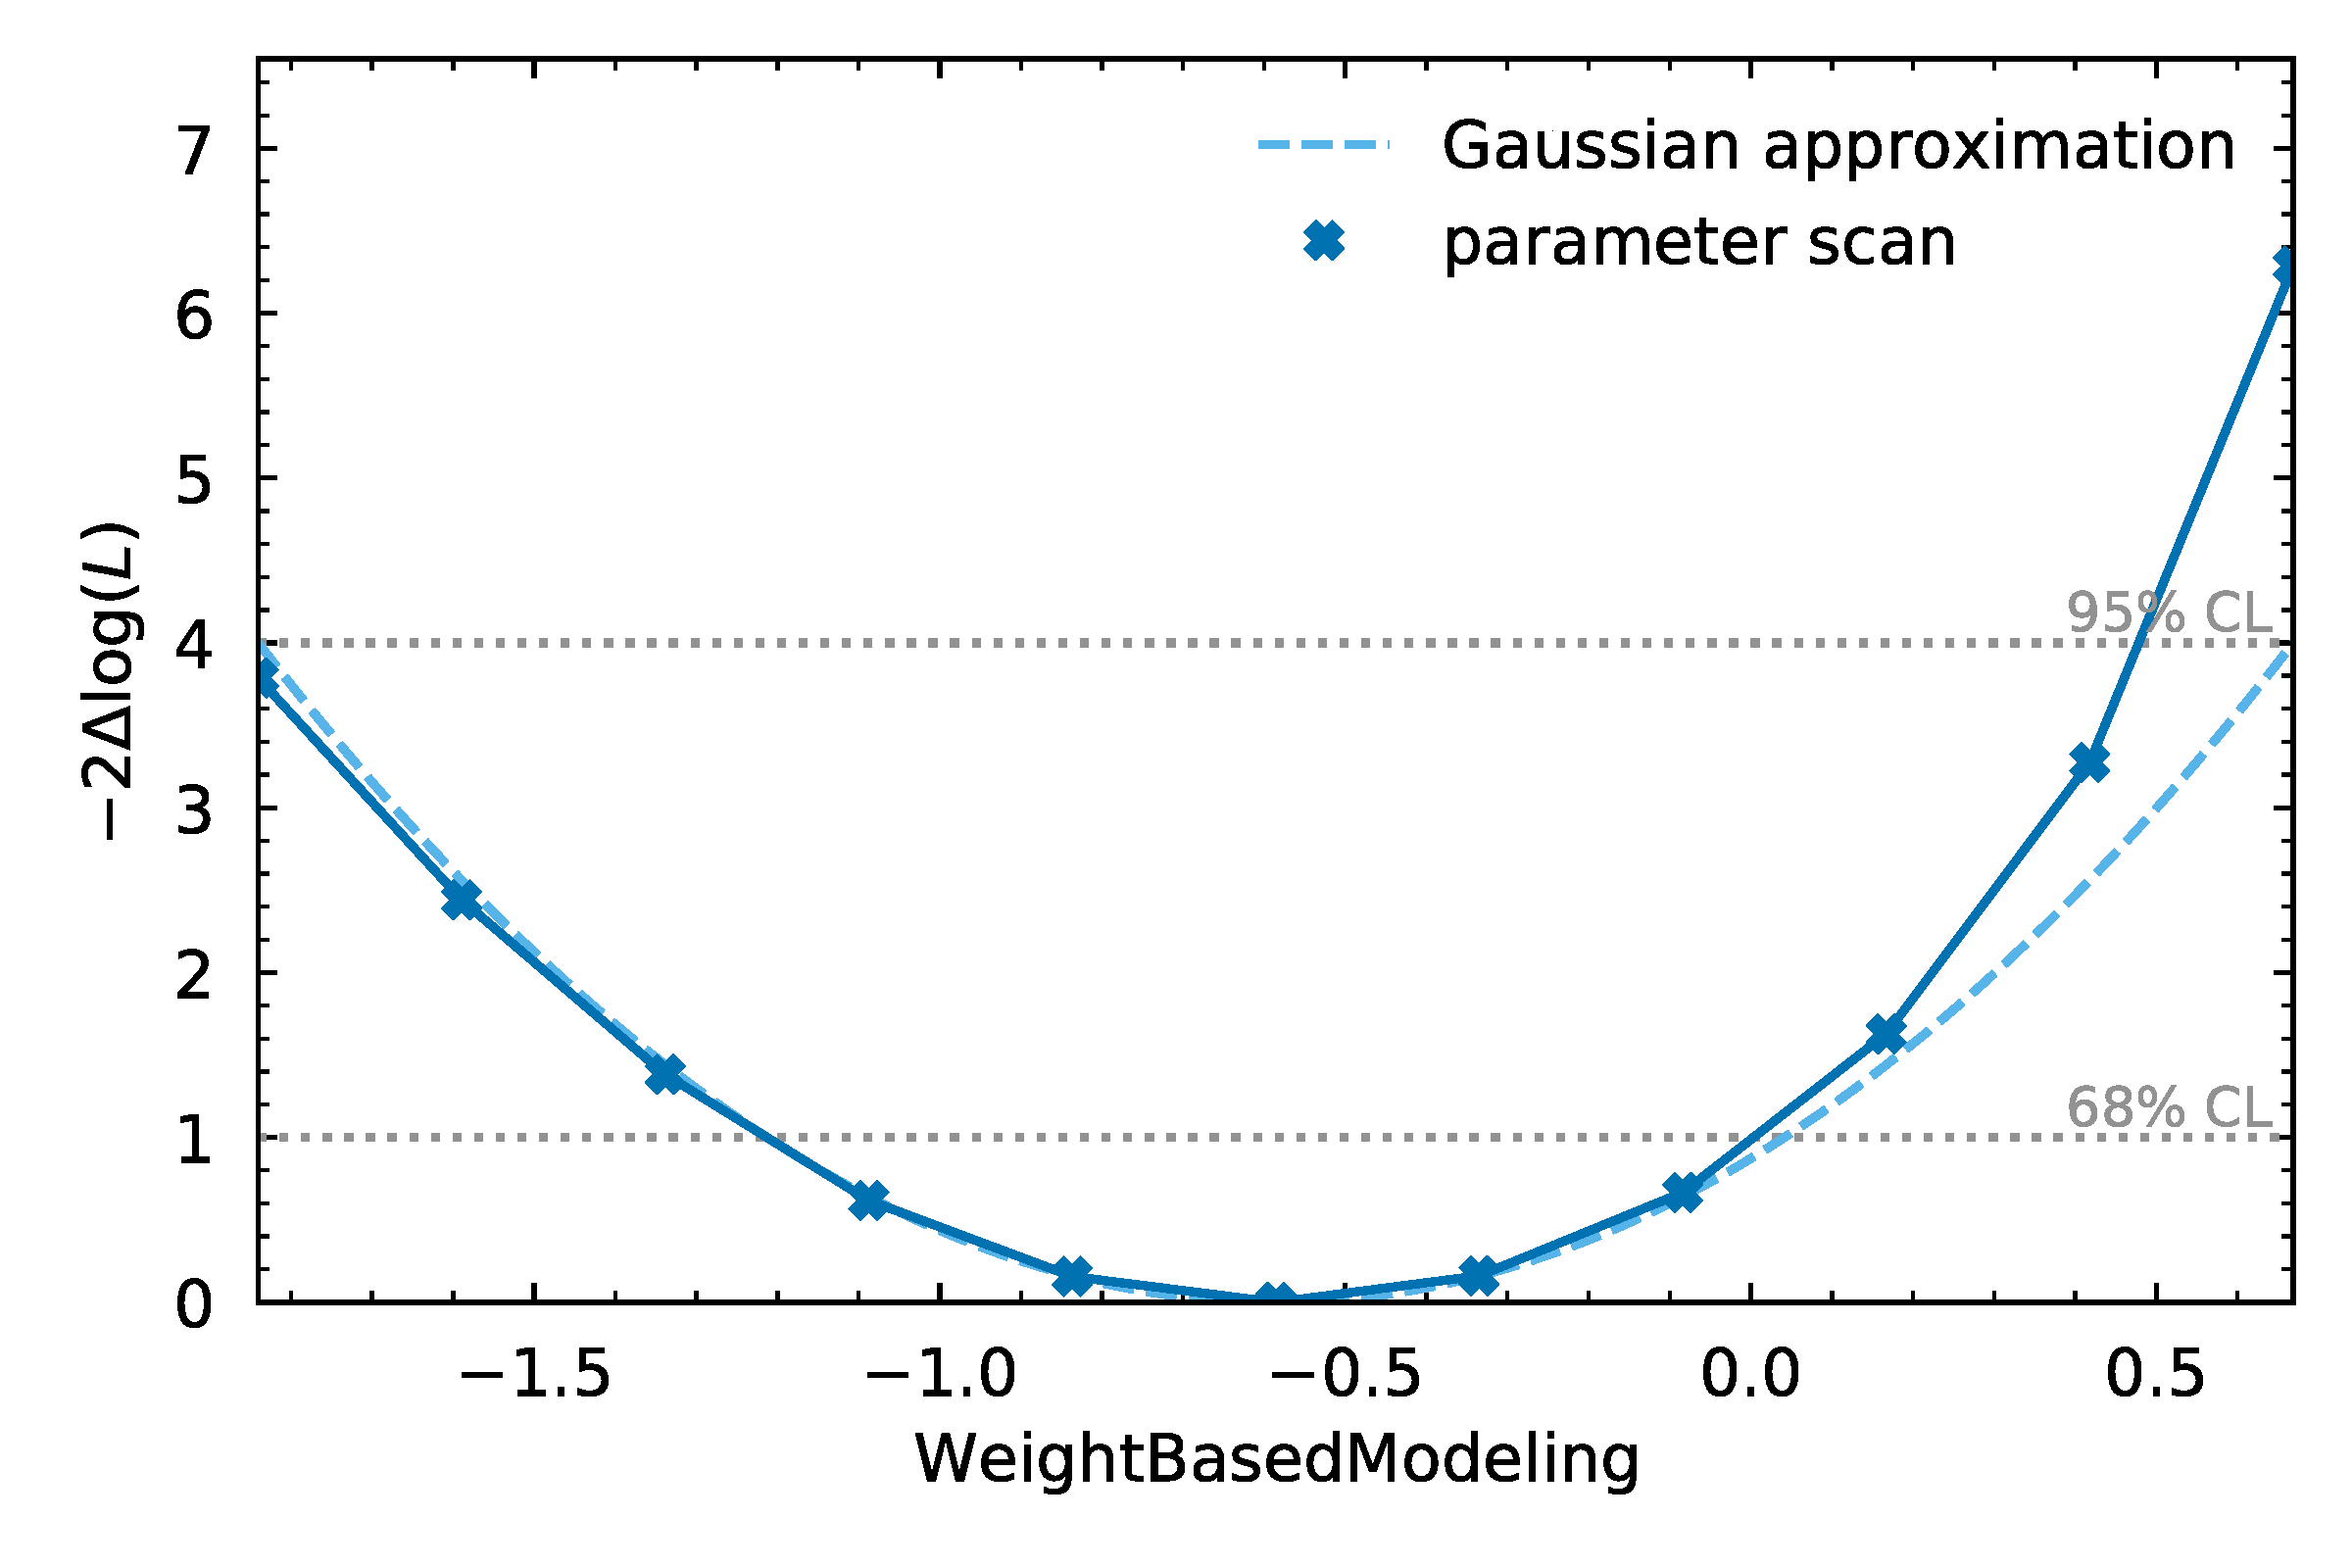

In [26]:
!gs -dSAFER -dBATCH -dNOPAUSE -dQUIET -sDEVICE=png16m -r400 \
  -sOutputFile="figures/scan_WeightBasedModeling.png" "figures/scan_WeightBasedModeling.pdf"
Image("figures/scan_WeightBasedModeling.png", width=400)

With `cabinetry.fit.limit`, we can evaluate observed and expected 95% confidence level upper parameter limits.
The implementation uses Brent bracketing to efficiently find the `CLs=0.05` crossing points.

In [27]:
limit_results = cabinetry.fit.limit(model, data)
cabinetry.visualize.limit(limit_results)

INFO - cabinetry.fit - calculating upper limit for Signal_norm
INFO - cabinetry.fit - determining observed upper limit
INFO - cabinetry.fit - successfully converged after 11 steps
INFO - cabinetry.fit - observed upper limit: 3.1564
INFO - cabinetry.fit - determining expected -2 sigma upper limit
INFO - cabinetry.fit - successfully converged after 9 steps
INFO - cabinetry.fit - expected -2 sigma upper limit: 1.0107
INFO - cabinetry.fit - determining expected -1 sigma upper limit
INFO - cabinetry.fit - successfully converged after 6 steps
INFO - cabinetry.fit - expected -1 sigma upper limit: 1.4000
INFO - cabinetry.fit - determining expected upper limit
INFO - cabinetry.fit - successfully converged after 6 steps
INFO - cabinetry.fit - expected upper limit: 1.9768
INFO - cabinetry.fit - determining expected +1 sigma upper limit
INFO - cabinetry.fit - successfully converged after 5 steps
INFO - cabinetry.fit - expected +1 sigma upper limit: 2.7101
INFO - cabinetry.fit - determining expecte

Again, the results are visualized:

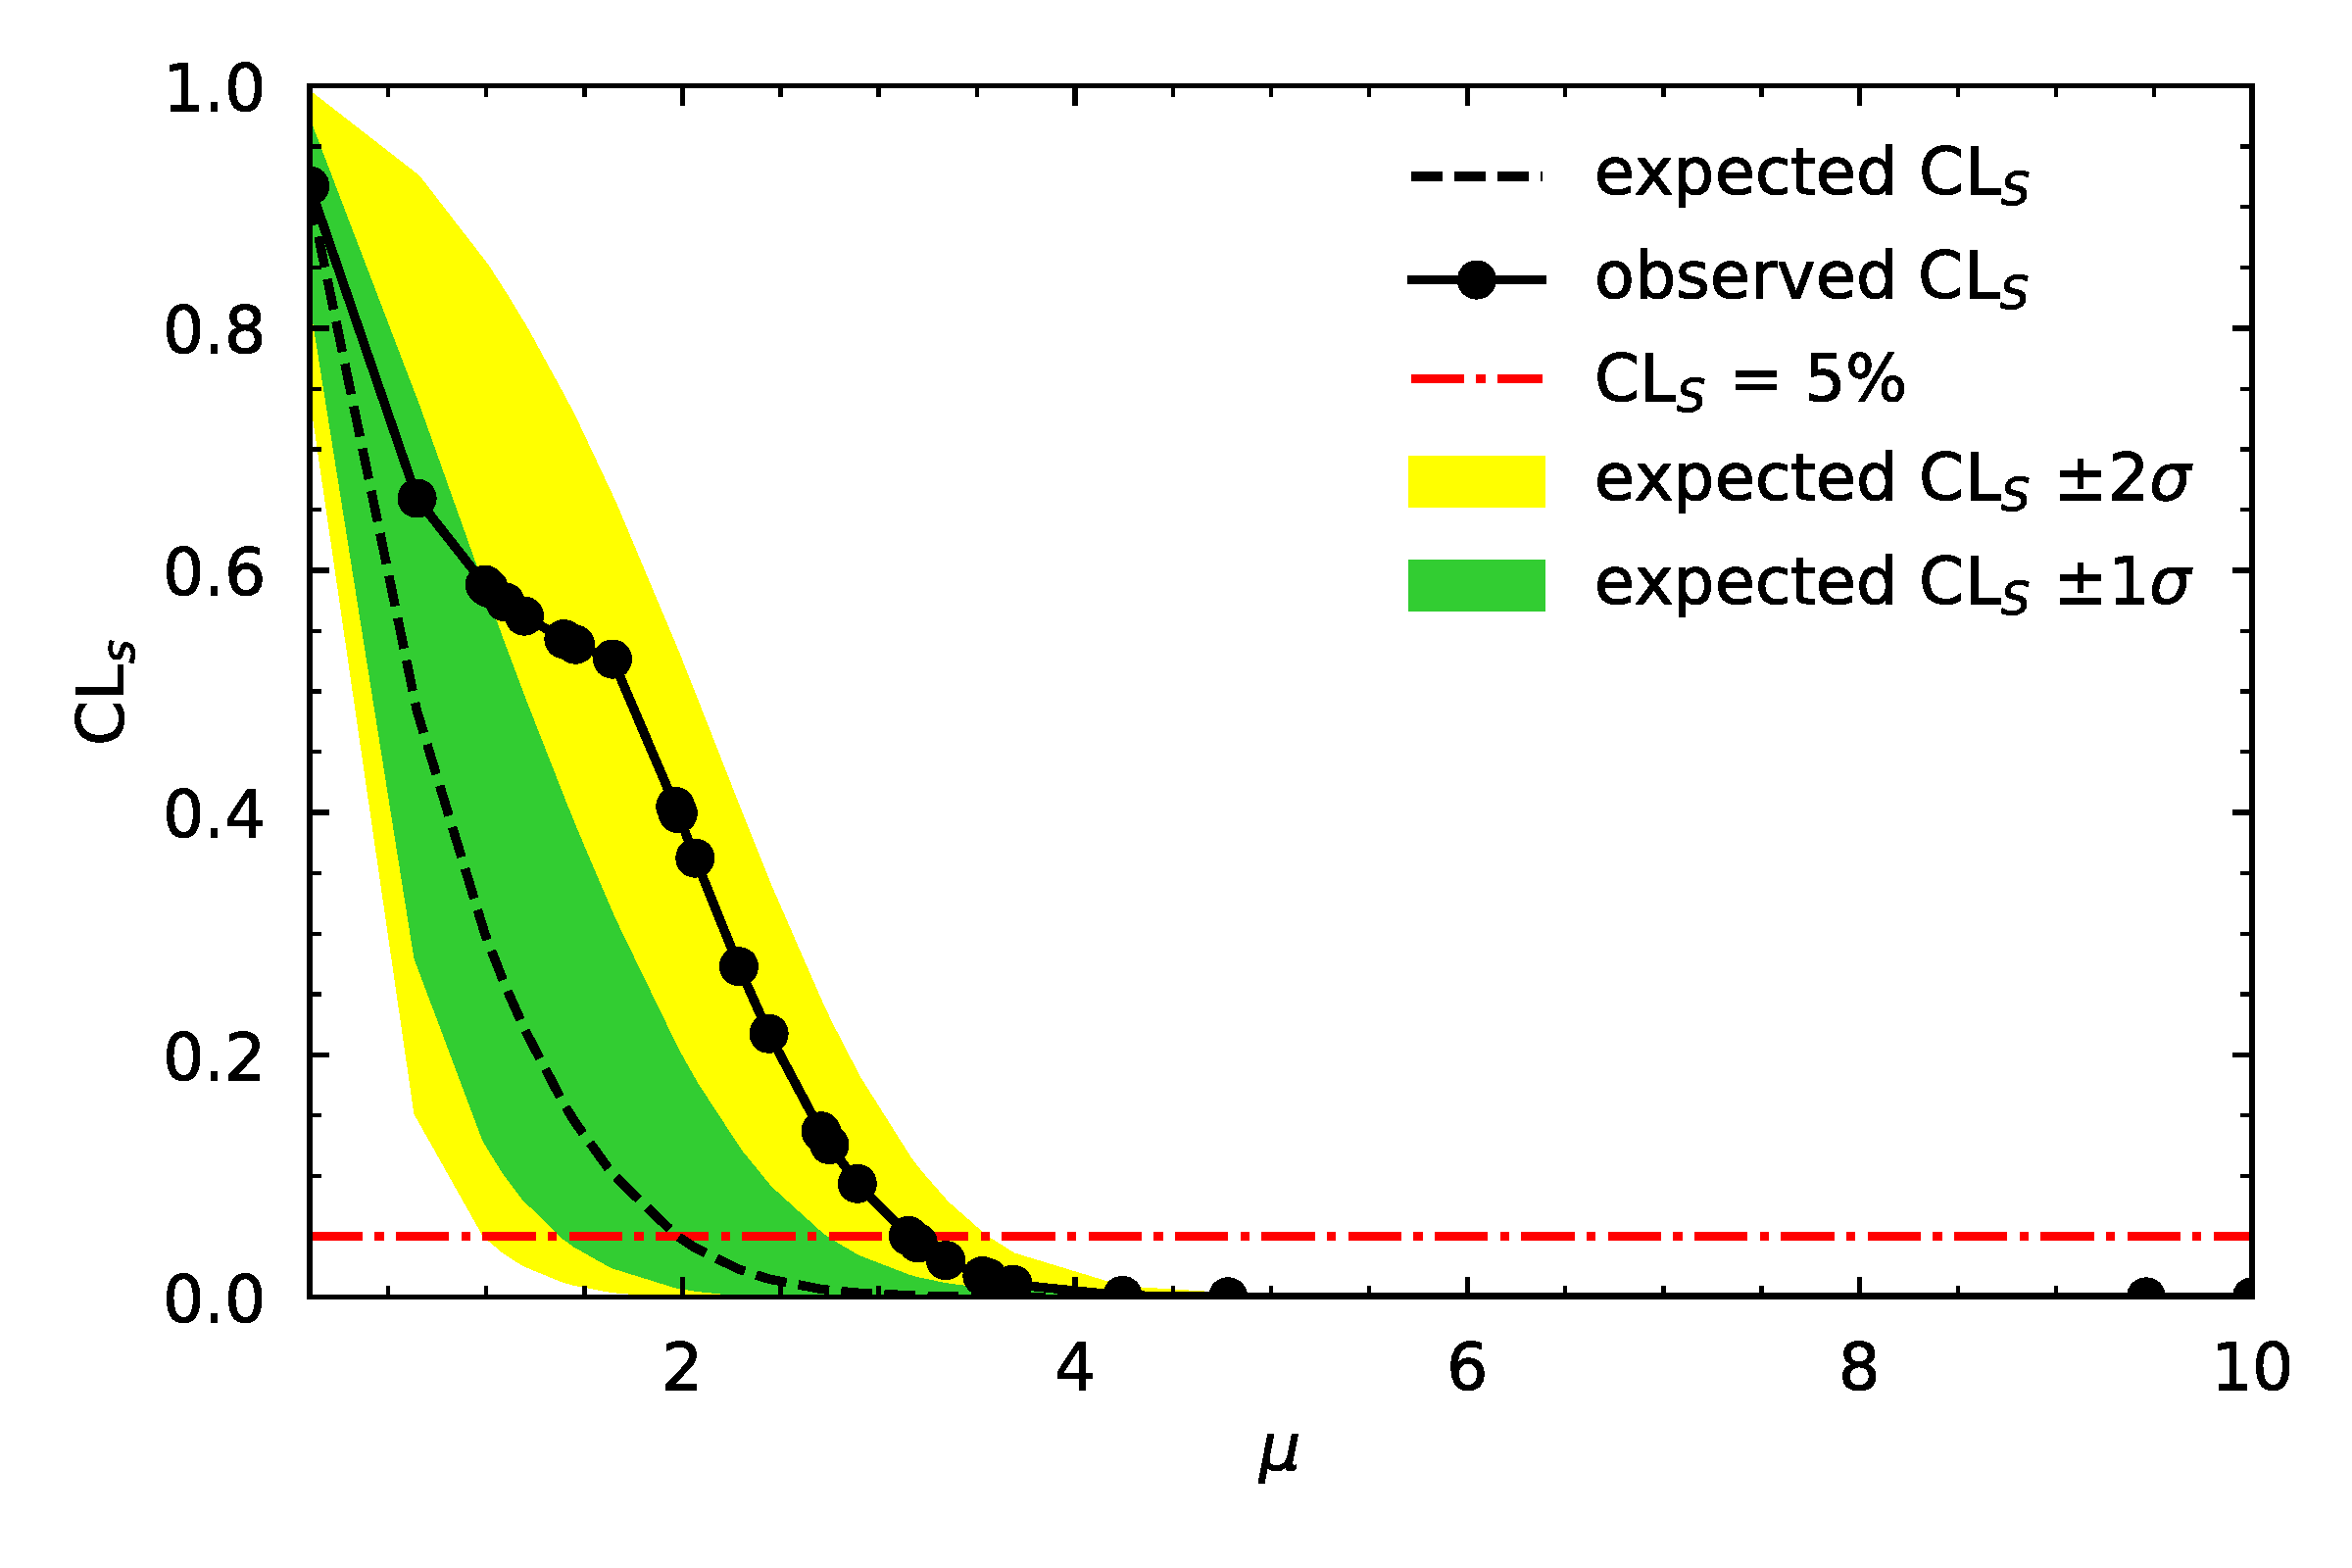

In [28]:
!gs -dSAFER -dBATCH -dNOPAUSE -dQUIET -sDEVICE=png16m -r400 -sOutputFile="figures/limit.png" "figures/limit.pdf"
Image("figures/limit.png", width=500)

The observed limits are above the expected limits.
We can calculate the discovery significance with `cabinetry.fit.significance`:

In [29]:
significance_results = cabinetry.fit.significance(model, data)

INFO - cabinetry.fit - calculating discovery significance
INFO - cabinetry.fit - observed p-value: 3.58366164%
INFO - cabinetry.fit - observed significance: 1.801
INFO - cabinetry.fit - expected p-value: 14.77504029%
INFO - cabinetry.fit - expected significance: 1.046


In this case, we observe a 1.8 sigma excess (and expected 1.0 sigma)